<a href="https://colab.research.google.com/github/LeeJaeEun0/PlayData_230125/blob/main/230125_ch06_DL_06_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 런타임 > 런타임 유형 변경 > 노트 설정 > 하드웨어 가속기 > GPU > 확인

# 데이터 준비하기

* 캡차 데이터셋
* https://www.kaggle.com/datasets/fournierp/captcha-version-2-images

In [ ]:
# https://www.kaggle.com/{본인ID}/account
# 본인 프로필 누르고 > Account
# > Create New API Token > kaggle.json
from google.colab import files

!pip install -q kaggle #kaggle 설치 # --quiet
# -- kaggle api를 사용하기 위한 인증파일을 설정 (8-11)
files.upload() #kaggle API file upload
!mkdir ~/.kaggle # kaggle 디렉토리 생성 / mkdir : make directory - 폴더 생성 (~)
!cp kaggle.json ~/.kaggle/ #kaggle.json 파일 kaggle 폴더에 복사 / cp a b (copy)
!chmod 600 ~/.kaggle/kaggle.json # 권한 변경 r w x (4 2 1)
# ---------
# !kaggle datasets list #kaggle 데이터셋 리스트 체크
# https://www.kaggle.com/datasets/fournierp/captcha-version-2-images
# ... > Copy API command
!kaggle datasets download -d fournierp/captcha-version-2-images

Saving kaggle.json to kaggle.json
 98% 17.0M/17.4M [00:01<00:00, 15.1MB/s]
100% 17.4M/17.4M [00:01<00:00, 9.68MB/s]


In [ ]:
!unzip captcha-version-2-images

Archive:  captcha-version-2-images.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflating: samples/2cegf.png       
  inflating: samples/2cg58.png       
  inflating: samples/2cgyx.png       
  inflating

In [ ]:
!ls

captcha-version-2-images.zip  kaggle.json  sample_data	samples


# 이미지 살펴보기

In [ ]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

samples/226md.png


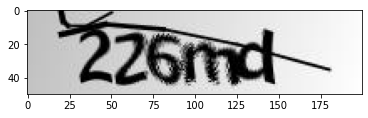

In [ ]:
imgfile = sorted(glob.glob(
    "samples/*.png"
))[0] # (특정 패턴을 만족시키는) 이미지 파일까지의 경로
print(imgfile)
imgfile = Image.open(imgfile) # 이미지 파일 로딩
plt.imshow(imgfile)
plt.show()

* 이미지 파일의 확장자는 png
* png 파일은 RGB 채널뿐만 아니라 투명도를 나타내는 알파 채널이 있음
* 일반적인 이미지 처리(pytorch 등)는 RGB를 전제로 하고 있기 때문에 이미지를 불러올 때 png 파일은 RGB로 변환

# 학습용 데이터셋 만들기

* 226md → 이 파일의 이름은 226md.png → 파일 이름에 해당하는 부분이 입력해야할 정답값
* 따라서 파일 이름에서 확장자인 .png를 떼어내고, 파일 이름 부분만 정답으로 이용
* (먼저) 정답에 등장하는 모든 문자들로부터 BOW를 만들어줘야함

## BOW를 만드는 함수

In [ ]:
# 문자들로부터 BOW를 만드는 함수
def get_BOW(corpus):
    # 공백문자 <pad>를 0으로 설정
    BOW = {"<pad>":0}

    # corpus의 문자들을 이용해서 BOW에 고유번호 추가
    for letter in corpus:
        if letter not in BOW.keys():
            BOW[letter] = len(BOW.keys())
    
    return BOW

get_BOW() 함수는 문자의 집합을 입력으로 받아 BOW를 반환하는 함수
* 먼저 공백문자를 나타내는 토큰의 고유번호를 0으로 설정
* 다음으로 모든 문자로부터 BOW를 생성, BOW에 들어 있지 않은 문자의 고유번호를 corpus 안에 들어 있는 순서대로 설정

# 데이터셋 객체 정의

In [ ]:
from torch.utils.data import Dataset
import string

In [ ]:
import numpy as np

In [ ]:
# 캡챠 데이터 셋
class Captcha(Dataset):
    # 생성자
    def __init__(self, path, train=True) -> None:
        # path : 이미지 파일이 있는 폴더의 경로
        # train : 훈련셋/시험셋 여부 결정
        super().__init__()
        # 소문자와 숫자만 정답으로 이용
        self.corpus = string.ascii_lowercase + string.digits
        # ascii_lowercase : 일반적으로 사용하는 알파벳 소문자 (영어 기준)
        # digits : 10진법의 숫자들
        self.BOW = get_BOW(self.corpus) # 영어소문자&숫자로 만든 corpus로 BOW

        # 불러올 이미지 파일의 경로
        self.imgfiles = sorted(glob.glob(path+"/*.png")) # 이미지 파일명을 오름차순으로 정리

        # 훈련셋/시험셋 -> 전체 이미지 파일 중에 80%는 -> 훈련셋, 20%는 시험셋
        self.train = train
        self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
        self.testset = self.imgfiles[int(len(self.imgfiles)*0.8):]
    
    # 캡차의 문자(파일명)로부터 정답(고유번호)을 생성하는 함수
    # 파일명에 있는 문자와 숫자를 고유번호로 치환
    def get_seq(self, line):
        # label = []
        # for letter in line:
        #     label.append(self.BOW[letter])
        # return label
        return [self.BOW[letter] for letter in line] # 리스트 컴프리헨션
    
    # 데이터 개수를 반환하는 함수 = __len__ -> len(...)
    # self.imgfiles의 길이를 반환 (학습이미지들)
    def __len__(self):
        # if self.train:
        #     return len(self.trainset)
        # else:
        #     return len(self.testset)
        return len(self.trainset) if self.train else len(self.testset) # 삼항연산자
    
    # 학습용 데이터를 처리
    # 한개씩 데이터를 불러올 때 변환
    def __getitem__(self, i):
        if self.train: # 훈련용 데이터일 경우
            # png 파일을 RGB파일로 변환
            data = Image.open(self.trainset[i]).convert('RGB')
            label = self.trainset[i].split("/")[-1] # samples/226md.png
            # sample / 226md.png (-1)
            # label = 226md.png
            # label = label.split(".png")[0] # 226md / ""
            label = label.replace(".png", "")
            # 파일이름에서 확장자를 제거 → 캡챠의 정답을 추출

            # BOW의 순열 -> 고유번호 리스트
            label = self.get_seq(label) # 숫자표현으로 바뀌게 됨

            # 이미지 처리
            # PIL -> ( 세로, 가로, 채널(색상)) -> (0, 1, 2)
            # 파이토치 -> (채널,세로 ,사로) -> (2, 0, 1)
            data = np.array(data).astype(np.float32) # 이미지를 읽어온 데이터 -> numpy
            # 파이토치 -> 채널이 가장 앞에 오도록 transpose
            data = np.transpose(data, (2, 0, 1))
            # A 배열의 차원 순서를 shape가 되도록 변경 -> np.transpose(A, shape)
            # 예를 들어 (224, 224, 3) 모양을 갖는 이미지를 A라고 할 때
            # shape를 (2, 0, 1)로 지정하면,
            # 모양의 2(0, 1, 2)번째 요소인 3(채널), 0번째 요소(가로), 1번째 요소(세로) 순으로 변경

            label = np.array(label)

            return data, label
        
        else: # 테스트 일 때
            # 검증용 데이터를 처리하는 코드
            data = Image.open(self.testset[i]).convert('RGB') # 테스트셋 읽어오기
            label = self.trainset[i].split("/")[-1]
            label = label.replace(".png", "")
            label = self.get_seq(label)

            data = np.array(data).astype(np.float32)
            # data = np.transpose(data, (2, 0, 1)) # 이미지와 결과값을 비교할 예정
            label = np.array(label)

            return data, label

# 모델 정의

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## 기본 블록 정의

In [ ]:
# 3 x 5 크기 커널 이용
class BasicBlock(nn.Module):
    # 생성자 정의 (레이어층)
    def __init__(self,
                 in_channels, # input
                 out_channels, # output
                 kernel_size=(3, 5),
                 stride=(2, 1)
                 ) -> None:
        super(BasicBlock, self).__init__()

        # 합성곱 레이어층 2개 정의 -> 커널 크기가 다름
        # (1) 첫번째 합성곱 -> 가로의 크기가 더 큰 (더 긴) 3 x 5 커널
        self.c1 = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=kernel_size,
                            stride=stride)
        # (2) 두번째 합성곱 -> 3 x 3 정사각형 커널
        # 가로 길이가 긴 커널을 이용해 추출한 특징을, 짧은 커널 사용해서 상세하게 학습
        self.c2 = nn.Conv2d(in_channels=out_channels,
                            out_channels=out_channels,
                            kernel_size=(3, 3),
                            padding=1)
        
        # ResNet을 위해 더해줄 원본 다운샘플링
        self.downsample = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=kernel_size,
                            stride=stride)
        
        # 배치 정규화를 통한 과최적화 방지
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # 활성화 함수
        self.relu = nn.ReLU()
    
    # 기본 블록의 순전파 정의
    # ResNet의 순전파 정의
    # 합성곱 -> 배치 정규화 -> x + x_(원본)를 더해서 출력
    def forward(self, x):
        x_ = x # 임시저장

        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)

        x_ = self.downsample(x_)

        x += x_
        x = self.relu(x)

        return x

In [ ]:
import torchsummary

bb = BasicBlock(3, 64).to('cuda' if torch.cuda.is_available else 'cpu')
torchsummary.summary(bb, (3, 200, 50), 8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [8, 64, 99, 46]           2,944
       BatchNorm2d-2            [8, 64, 99, 46]             128
              ReLU-3            [8, 64, 99, 46]               0
            Conv2d-4            [8, 64, 99, 46]          36,928
       BatchNorm2d-5            [8, 64, 99, 46]             128
            Conv2d-6            [8, 64, 99, 46]           2,944
              ReLU-7            [8, 64, 99, 46]               0
Total params: 43,072
Trainable params: 43,072
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.92
Forward/backward pass size (MB): 124.52
Params size (MB): 0.16
Estimated Total Size (MB): 125.60
----------------------------------------------------------------


## CRNN 모델 정의

In [ ]:
class CRNN(nn.Module):
    # 생성자
    def __init__(self, output_size) -> None:
        super(CRNN, self).__init__()

        # CNN층 정의
        self.c1 = BasicBlock(in_channels=3, out_channels=64)
        self.c2 = BasicBlock(in_channels=64, out_channels=64)
        self.c3 = BasicBlock(in_channels=64, out_channels=64)
        self.c4 = BasicBlock(in_channels=64, out_channels=64)
        self.c5 = nn.Conv2d(64, 64, kernel_size=(2, 5)) # 세로 픽셀을 1로 줄이기 위한 합성곱층

        # 특징 맵 -> 텍스트 정보를 추출할 GRU층
        self.gru = nn.GRU(64, 64, batch_first=False)

        # 분류를 위한 MLP층, FC층
        self.fc1 = nn.Linear(in_features=64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=output_size)
        self.relu = nn.ReLU()
    
    # 순전파
    def forward(self, x): # x 인풋을 받아서
        # 입력할 때 텐서 모양 : (배치사이즈, 3, 50, 200)
        # B, 3, 50, 200
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.c5(x)
        # 합성곱 층 -> 이미지 모양이 (B, 64, 1, 180) # 세로1, 가로180
        
        # GRU층에 입력
        # (B, 64, 1, 180) -> (B, 64, 180)
        x = x.view(x.shape[0], 64, -1)
        # (180, B, 64)로 변경 (가로 길이를 맨 앞에 시계열로 배치)
        x = x.permute(2, 0, 1)

        # 시계열 준비 -> GRU의 입력
        x, _ = self.gru(x)

        # GRU의 모든 시점의 은닉상태 -> MLP층으로 넣어주면
        # 각 픽셀이 어떤 문자인지 알 수 있음
        # FC층으로 각 픽셀 분류
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        # CTC 손실 계산을 위해 로그 소프트 맥스를 이용해 출력을 내보냄
        # 로그 소프트맥스 함수 -> 소프트맥스에 로그를 취한 함수
        x = F.log_softmax(x, dim=-1)

        return x

# 모델 학습하기

In [ ]:
from tqdm.notebook import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

file_path = 'samples/'

dataset = Captcha(path=file_path)
print(len(dataset.BOW)) # 0은 pad (0-9, a-z => 10, 26, 1 => 37)
loader = DataLoader(dataset, batch_size=8)

model = CRNN(output_size=len(dataset.BOW)).to(device)
optim = Adam(model.parameters(), lr=0.0001) # 1e-4
# 37 => 패딩포함

37


In [ ]:
torchsummary.summary(model, (3, 50, 200), 8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [8, 64, 24, 196]           2,944
       BatchNorm2d-2           [8, 64, 24, 196]             128
              ReLU-3           [8, 64, 24, 196]               0
            Conv2d-4           [8, 64, 24, 196]          36,928
       BatchNorm2d-5           [8, 64, 24, 196]             128
            Conv2d-6           [8, 64, 24, 196]           2,944
              ReLU-7           [8, 64, 24, 196]               0
        BasicBlock-8           [8, 64, 24, 196]               0
            Conv2d-9           [8, 64, 11, 192]          61,504
      BatchNorm2d-10           [8, 64, 11, 192]             128
             ReLU-11           [8, 64, 11, 192]               0
           Conv2d-12           [8, 64, 11, 192]          36,928
      BatchNorm2d-13           [8, 64, 11, 192]             128
           Conv2d-14           [8, 64, 

In [ ]:
for epoch in range(200):
    iterator = tqdm(loader)

    # CTC 손실 계산 -> 4개의 입력값
    # 1. 신경망의 출력값 -> CRNN의 출력값 preds
    # 2. 정답 -> label
    # 3. 입력값의 모양 -> preds_size
    # 4. 최종적인 예측값의 모양 -> 텍스트의 길이? 배치 크기가 8개 -> 벡터로 값을 묶어줘야함
    #    target_len

    for data, label in iterator: # (2) : label
        optim.zero_grad()
        preds = model(data.to(device)) # CRNN의 출력값 (1)
        # CTC 손실 계산을 위한 텐서의 모양을 정의
        # 정수형으로 간단하게 preds와 label을 모양 정의
        
        # 시계열을 묶은 모양을 나타내는 변수 (3)
        preds_size = torch.IntTensor([preds.size(0)] * 8).to(device)
        # 정답의 모양을 나타내는 변수 (4)
        target_len = torch.IntTensor([len(txt) for txt in label]).to(device)

        # CTC 손실 계산
        loss = nn.CTCLoss(blank=0)(
            preds, label.to(device), preds_size, target_len
        )

        loss.backward()
        optim.step()

        iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CRNN.pt")

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

# 모델 성능 평가하기

tensor([[[-1.1921e-07, -2.9196e+01, -2.0076e+01,  ..., -2.0377e+01,
          -2.0396e+01, -2.9137e+01]],

        [[ 0.0000e+00, -3.1719e+01, -2.1786e+01,  ..., -2.2052e+01,
          -2.1753e+01, -3.1714e+01]],

        [[ 0.0000e+00, -3.2243e+01, -2.2355e+01,  ..., -2.2678e+01,
          -2.1924e+01, -3.2218e+01]],

        ...,

        [[ 0.0000e+00, -3.2514e+01, -2.2683e+01,  ..., -2.2924e+01,
          -2.1894e+01, -3.2426e+01]],

        [[ 0.0000e+00, -3.2518e+01, -2.2681e+01,  ..., -2.2934e+01,
          -2.1896e+01, -3.2430e+01]],

        [[ 0.0000e+00, -3.2524e+01, -2.2682e+01,  ..., -2.2950e+01,
          -2.1897e+01, -3.2436e+01]]], device='cuda:0')


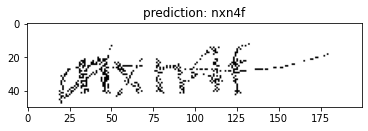

In [ ]:
model.load_state_dict(torch.load("CRNN.pt", map_location=device))

with torch.no_grad():

   testset = Captcha(path=file_path, train=False)
#    idx = 10 #@param {"type":"number"}
   idx = 0
   test_img, label = testset[idx] # 50, 200, 3
   input_tensor = torch.unsqueeze(torch.tensor(test_img), dim=0) # 1, 50, 200, 3
   input_tensor = input_tensor.permute(0, 3, 1, 2).to(device) # 1, 3, 50, 200

   # 가장 높은 확률을 갖는 글자를 추출
   output = model(input_tensor)
   print(output)
   pred = torch.argmax(output, dim=-1) # -1 => 가장 안쪽 차원에서 가장 높은 값의 indx
   # [고유번호들의 리스트]

   # 글자 간의 중복을 제거
   # 하나의 글자를 나타내는 데 여러 픽셀이 이용되기 때문에 글자의 중복이 발생
   # 예를 들어 hhh-eell-ll-o와 같이 신경망이 예측했다면
   # -(글자가 없는 공백)이 나오기 전까지, 혹은 다른 글자가 나오기 전까지 겹치는 글자는 중복
   prev_letter = pred[0].item() # 스칼라
   pred_word = ""
   for letter in pred:
       if letter.item() != 0 and letter.item() != prev_letter: # 0은 공백
           pred_word += list(testset.BOW.keys())[letter.item()]
       prev_letter = letter.item()

   plt.imshow(test_img)
   plt.title("prediction: "+ pred_word)
   plt.show()

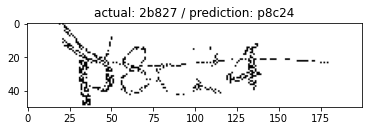

In [ ]:
model.load_state_dict(torch.load("CRNN.pt", map_location=device))

with torch.no_grad():

   testset = Captcha(path=file_path, train=False)
   idx = 20 #@param {"type":"number"}
#    idx = 0
   test_img, label = testset[idx] # 50, 200, 3
   input_tensor = torch.unsqueeze(torch.tensor(test_img), dim=0) # 1, 50, 200, 3
   input_tensor = input_tensor.permute(0, 3, 1, 2).to(device) # 1, 3, 50, 200

   # 가장 높은 확률을 갖는 글자를 추출
   output = model(input_tensor)
#    print(output)
   pred = torch.argmax(output, dim=-1) # -1 => 가장 안쪽 차원에서 가장 높은 값의 index
   # -> [[고유번호들의 배열]]
#    print(pred)

   # 글자 간의 중복을 제거
   # 하나의 글자를 나타내는 데 여러 픽셀이 이용되기 때문에 글자의 중복이 발생
   # 예를 들어 hhh-eell-ll-o와 같이 신경망이 예측했다면
   # -(글자가 없는 공백)이 나오기 전까지, 혹은 다른 글자가 나오기 전까지 겹치는 글자는 중복
   prev_letter = pred[0].item() # 스칼라
   pred_word = ""
   for letter in pred:
       if letter.item() != 0 and letter.item() != prev_letter: # 0은 공백
           pred_word += list(testset.BOW.keys())[letter.item()]
       prev_letter = letter.item()

   plt.imshow(test_img)
   plt.title("actual: "+ "".join([list(testset.BOW.keys())[l.item()] for l in label]) + " / prediction: "+ pred_word)
   plt.show()